In [ ]:
#!pip3 install sklearn
#!pip3 install xgboost

## 1. Librerias, Funciones y Parámetros Iniciales

In [1]:
from PIL import Image
import os
from os import listdir
from os.path import isfile, join
import numpy as np
from tqdm.notebook import tqdm
import cv2
import pickle
from sklearn.model_selection import train_test_split as tts
import pandas as pd
from time import sleep
from IPython.display import clear_output
import numpy as np

xVectorSize=100
yVectorSize=100

def getImageVector(img):
    #img = Image.open(img)
    img = img.resize( (xVectorSize, yVectorSize) )
    img = img.convert('L')
    return imgToVector(img) 

#Funcion para vectorizar imagenes y asignales clasificación
def imgToVector(img,x=xVectorSize,y=yVectorSize,classification=1):
    vector=[]
    vector.append(classification)

    for j in range(y):
        for i in range(x):
            vector.append(img.getpixel((i,j)))
    return vector

def reconstructor(vector,x=xVectorSize,y=yVectorSize):
    reb=Image.new('L',(x,y))
    for j in range(y):
        for i in range(x):
            reb.putpixel((i,j),vector[i+j*x]) 
    return reb

def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

def faceslocation(imgpath,foi='file'):
    if foi=='file':
        original_image = cv2.imread(imgpath)
    elif foi=="img":
        original_image = imgpath
    
    
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    detected_faces = face_cascade.detectMultiScale(grayscale_image)
    return detected_faces

def getfaces(imgpath, foi='file'):
    
    if foi == 'file':
        source = Image.open(imgpath)
        source = source.convert('L')
        detected_faces=faceslocation(imgpath)
    elif foi == 'img':
        source = cv2.cvtColor(imgpath, cv2.COLOR_BGR2GRAY)
        detected_faces=faceslocation(imgpath,foi="img")
        
    faces=[]
    
    for i in detected_faces:
        tlbr=list(i)
        
        x=int(tlbr[2])
        y=int(tlbr[3])
        x_offset=int(tlbr[0])
        y_offset=int(tlbr[1])
        
        if foi == 'file':
            face=Image.new('L',(x,y))
            for j in range(y):
                for i in range(x):
                    pixel=source.getpixel((i+x_offset,j+y_offset))
                    face.putpixel((i,j),pixel) 
            faces.append(face)
        elif foi == 'img':
            face=np.array()
            for j in range(y):
                for i in range(x):
                    pixel=source[i+x_offset,j+y_offset]
                    face.putpixel((i,j),pixel) 
            faces.append(face)
    
    mask=[] 
    for face in faces:
        X=pd.DataFrame(getImageVector(face)).T
        X=X.drop(0,axis=1)
        pred=xgbc.predict(X)
        mask.append(pred)
           
    return faces,mask

def textInImage(img,text='Prueba Texto'):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (50,50)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(img,text, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
def idSquare(imgpath,fl,pred,foi='file'):
    if foi == 'file':
        img = cv2.imread(imgpath)
    elif foi == 'img':
        img=imgpath
        

    for i in range(len(fl)):
        
        column=fl[i][0]
        row=fl[i][1]
        width=fl[i][2]
        height=fl[i][3]
        
        if pred[i][0]== 0:
            color=(0,0,255)
        else:
            color =(0,255,0)
        
        cv2.rectangle(
            img,
            (column, row),
            (column + width, row + height),
            color,
            2)
    
    return img

def maskdetector(imgpath,foi='file'):
    if foi == 'file':
        original_image = cv2.imread(imgpath)
        detected_faces=faceslocation(imgpath)
        faces,mask=getfaces(imgpath)
        img=idSquare(imgpath,detected_faces,mask)
    elif foi == 'img':
        detected_faces=faceslocation(imgpath,foi='img')
        faces,mask=getfaces(imgpath,foi='img')
        img=idSquare(imgpath,detected_faces,mask, foi='img')
        
    return img

## 2.Carga de modelo guardado

In [2]:
xgbc = []
with (open("xgbc100x100", "rb")) as openfile:
    while True:
        try:
            xgbc.append(pickle.load(openfile))
        except EOFError:
            break
xgbc=xgbc[0]

## 3.Captura desde Cámara y Aplicación de Modelo para deteccion de rostros con y sin cubrebocas

In [ ]:
cam = cv2.VideoCapture(0)
cv2.startWindowThread()

cv2.namedWindow("test")

stop=False
while stop==False:
    ret, frame = cam.read()
    imgpath='current_img.png'
    cv2.imwrite(imgpath, frame)
    
    #clear_output(wait=True)
    img=maskdetector(imgpath)
    #img=maskdetector(frame,'img')
    try:
        frame50 = rescale_frame(img,percent=50)
        cv2.imshow("test", frame50)
    except:
        pass

        
    
     
    k = cv2.waitKey(1)
    if k%256 == 27: # ESC pressed
        print("Escape hit, closing...")
        stop=True
    

cam.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
print('End')

## Rutinas de Prueba

### A. Apertura de Imagen para vectorizacion y despliegue

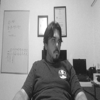

In [3]:
img=Image.open('current_img.png')
X=pd.DataFrame(getImageVector(img)).T
X=X.drop(0,axis=1)
prediccion=xgbc.predict(X)
X=list(X.T[0])
grayscale_image=reconstructor(X)
grayscale_image

### B. Obteneción de Imagen de Webcam

In [4]:
cam = cv2.VideoCapture(0)
cv2.namedWindow("test")
ret, frame = cam.read()
frame50 = rescale_frame(frame,percent=50)
cv2.imshow("test", frame50)

cv2.imwrite("current_img.png", frame)
print('Release')
cam.release()
print('Destroy')
cv2.destroyAllWindows()
print('End')

Release
Destroy
End


### C. Despliegue de caras detectadas

11
[0]


[0]


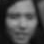

[0]


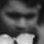

[0]


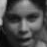

[1]


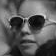

[1]


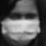

[1]


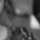

[1]


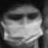

[1]


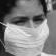

[1]


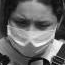

[0]


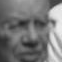

In [12]:
imgpath='TestImages/Test2.jpg'
faces,mask=getfaces(imgpath)
print(len(faces))
#for i in range(len(faces)):
#    print(mask[i])
#    display(faces[i])

### D. Cuadros de Identificacion

## Rutinas para entrenar nuevos modelos

In [ ]:
#Cargando datos para entrenar

mask = []
with (open("mask.pickle", "rb")) as openfile:
    while True:
        try:
            mask.append(pickle.load(openfile))
        except EOFError:
            break
mask=mask[0]

nomask = []
with (open("nomask.pickle", "rb")) as openfile:
    while True:
        try:
            nomask.append(pickle.load(openfile))
        except EOFError:
            break
nomask=nomask[0]

XYTrain=mask+nomask
XYTrain = pd.DataFrame(XYTrain)

X_train, X_test, y_train, y_test=tts(XYTrain.drop(0, axis=1),XYTrain[0], test_size=0.2, random_state=101)
#X_train, X_test, y_train, y_test=tts(XYTrain.drop(0, axis=1),XYTrain[0], test_size=1, random_state=101)

In [ ]:
from xgboost import XGBClassifier as XGBC

xgbc=XGBC()
xgbc.fit(X_train, y_train)

train_score=xgbc.score(X_train, y_train)
test_score=xgbc.score(X_test, y_test)

print (train_score, test_score)

pickle.dump(xgbc,open("xgbc","wb"))